Last updated on May 21, 2023

# Direct inversion algorithm for reference state computation

This notebook computes LWA and reference states from the same dataset as in `demo_script_for_nh2018.ipynb` but use the new boundary conditions outlined in NHN22:

Neal, E., Huang, C. S., & Nakamura, N. (2022). [The 2021 Pacific Northwest heat wave and associated blocking: meteorology and the role of an upstream cyclone as a diabatic source of wave activity.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL097699) *Geophysical Research Letters*, 49(8), e2021GL097699.

See the code under **Additional parameters needed to switch to NHN22 boundary conditions** for additional parameters needed to compute reference states with NHN22 boundary conditions.

---

From release `v0.7.0`, users can choose the version of boundary conditions to compute reference states via the child class of `QGField`. To compute reference states using boundary condition in NHN22, one could initialized the corresponding `QGField` child class:

```python
QGFieldNHN22(xlon, ylat, plev, uu, vv, tt, eq_boundary_index=5)
```

*NOTE THAT THE PROCEDURES USING THIS NEW PROTOCOL IS STILL __EXPERIMENTAL__. SUBSTANTIAL CHANGES MAY OCCUR IN THE FUTURE.*

---

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [1]:
import numpy as np
from numpy import dtype
from math import pi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from hn2016_falwa.oopinterface import QGFieldNHN22
import hn2016_falwa.utilities as utilities
import datetime as dt

## Sample data

The netCDF dataset used below can be downloaded from [Clare's Dropbox folder](https://www.dropbox.com/scl/fo/b84pwlr7zzsndq8mpthd8/h/notebooks/nh2018_science?dl=0&subfolder_nav_tracking=1). It is retrieved from:
https://cds.climate.copernicus.eu/#!/home

In [2]:
# --- Load the zonal wind and QGPV at 240hPa --- #
u_file = Dataset('2005-01-23_to_2005-01-30_u.nc', mode='r')
v_file = Dataset('2005-01-23_to_2005-01-30_v.nc', mode='r')
t_file = Dataset('2005-01-23_to_2005-01-30_t.nc', mode='r')

time_array = u_file.variables['time'][:]
time_units = u_file.variables['time'].units
time_calendar = u_file.variables['time'].calendar
ntimes = time_array.shape[0]

print('Dimension of time: {}'.format(time_array.size))

Dimension of time: 32


## Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [3]:
xlon = u_file.variables['longitude'][:]

# latitude has to be in ascending order
ylat = u_file.variables['latitude'][:]
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.variables['level'][:]
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
equator_idx = nlat//2+1
nlev = plev.size

Flip ylat.
Flip plev.


In [4]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

## Create a netCDF file to store output

A netCDF file `2005-01-23_to_2005-01-30_output.nc` with same number of time steps in the input file is created to store all the computed quantities.

In [5]:
# === Outputing files ===
output_fname = '2005-01-23_to_2005-01-30_output_nhn22.nc'
output_file = Dataset(output_fname, 'w')
output_file.createDimension('levelist',kmax)
output_file.createDimension('latitude',nlat)
output_file.createDimension('longitude',nlon)
output_file.createDimension('time',ntimes) 
plevs = output_file.createVariable('levelist',dtype('float32').char,('levelist',)) # Define the coordinate variables
lats = output_file.createVariable('latitude',dtype('float32').char,('latitude',)) # Define the coordinate variables
lons = output_file.createVariable('longitude',dtype('float32').char,('longitude',))
times = output_file.createVariable('time',dtype('int').char,('time',))    
plevs.units = 'hPa' 
lats.units = 'degrees_north'
lons.units = 'degrees_east'
times.units = time_units
times.calendar = time_calendar
plevs[:] = p0 * np.exp(-height/hh)
lats[:]  = ylat 
lons[:]  = xlon
times[:] = time_array
qgpv = output_file.createVariable('qgpv',dtype('float32').char,('time','levelist','latitude','longitude'))
qgpv.units = '1/s' 
interpolated_u = output_file.createVariable('interpolated_u',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_u.units = 'm/s' 
interpolated_v = output_file.createVariable('interpolated_v',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_v.units = 'm/s'
interpolated_theta = output_file.createVariable('interpolated_theta',dtype('float32').char,('time','levelist','latitude','longitude'))
interpolated_theta.units = 'K' 
qref = output_file.createVariable('qref',dtype('float32').char,('time','levelist','latitude'))
qref.units = '1/s' 
uref = output_file.createVariable('uref',dtype('float32').char,('time','levelist','latitude'))
uref.units = 'm/s' 
ptref = output_file.createVariable('ptref',dtype('float32').char,('time','levelist','latitude'))
ptref.units = 'K' 
lwa = output_file.createVariable('lwa',dtype('float32').char,('time','levelist','latitude','longitude'))
lwa.units = 'm/s'
adv_flux_f1 = output_file.createVariable('Zonal advective flux F1',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f1.units = 'm**2/s**2'    
adv_flux_f2 = output_file.createVariable('Zonal advective flux F2',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f2.units = 'm**2/s**2'  
adv_flux_f3 = output_file.createVariable('Zonal advective flux F3',dtype('float32').char,('time','latitude','longitude'))
adv_flux_f3.units = 'm**2/s**2'  
adv_flux_conv = output_file.createVariable('Zonal advective flux Convergence -Div(F1+F2+F3)',dtype('float32').char,('time','latitude','longitude'))
adv_flux_conv.units = 'm/s**2'  
divergence_eddy_momentum_flux = output_file.createVariable('Eddy Momentum Flux Divergence',dtype('float32').char,('time','latitude','longitude'))
divergence_eddy_momentum_flux.units = 'm/s**2'  
meridional_heat_flux = output_file.createVariable('Low-level Meridional Heat Flux',dtype('float32').char,('time','latitude','longitude'))
meridional_heat_flux.units = 'm/s**2' 
lwa_baro = output_file.createVariable('lwa_baro',dtype('float32').char,('time','latitude','longitude'))
lwa_baro.units = 'm/s' 
u_baro = output_file.createVariable('u_baro',dtype('float32').char,('time','latitude','longitude'))
u_baro.units = 'm/s' 

## Set the level of pressure and the timestamp to display below

In [6]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0

## Additional parameters to compute reference state from NHN22 boundary conditions

In [7]:
eq_boundary_index = 3

## Loop through the input file and store all the computed quantities in a netCDF file

/Users/claresyhuang/Dropbox/GitHub/hn2016_falwa/hn2016_falwa/oopinterface.py:99: UserWarning: ylat is a masked array of dimension (121,) with 0 masked elements and fill value 1e+20. 
  warnings.warn(


 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61


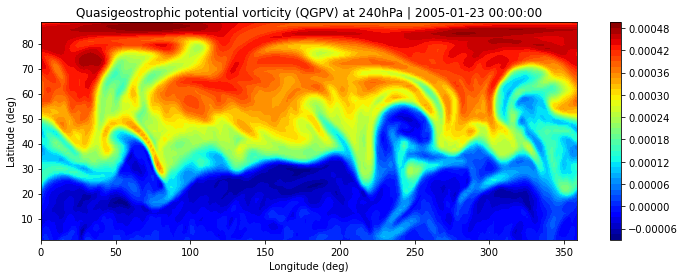

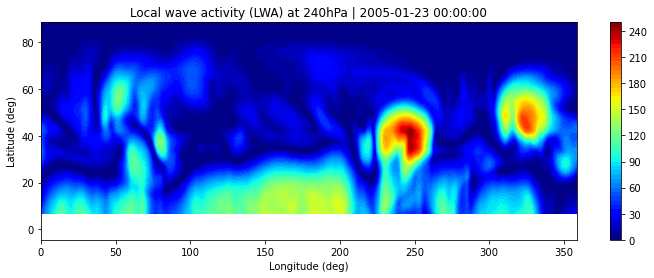

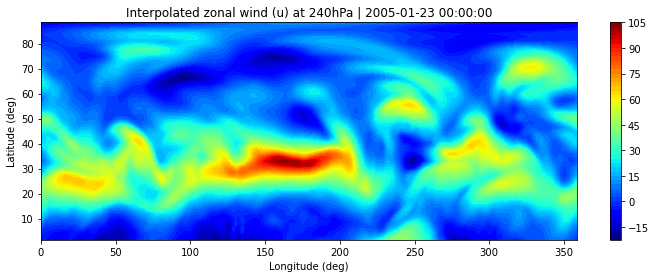

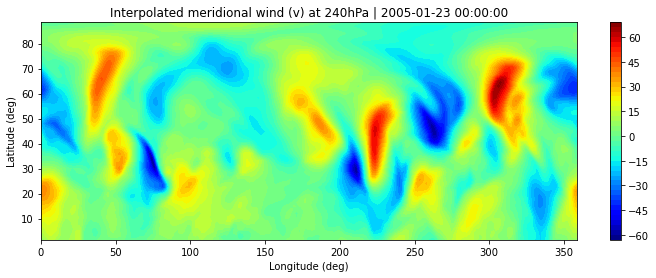

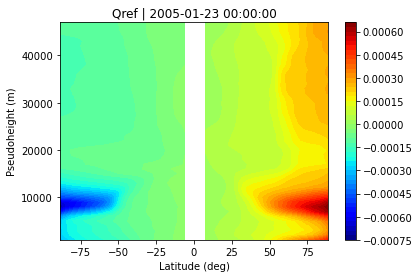

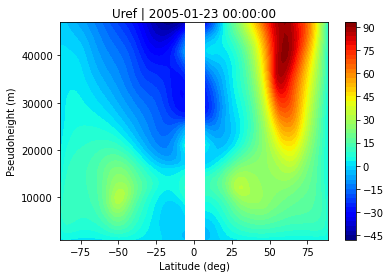

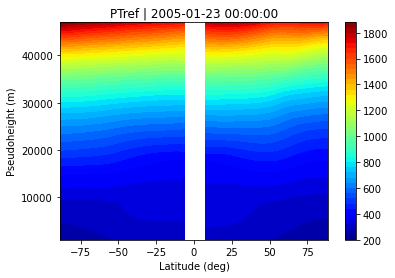

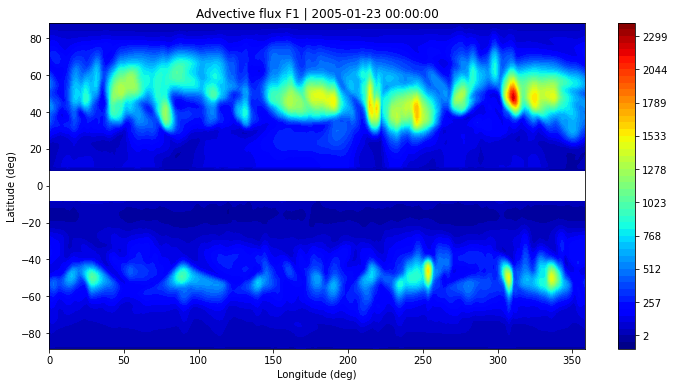

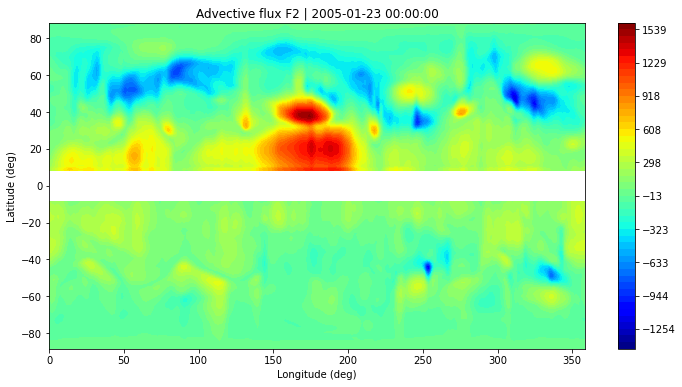

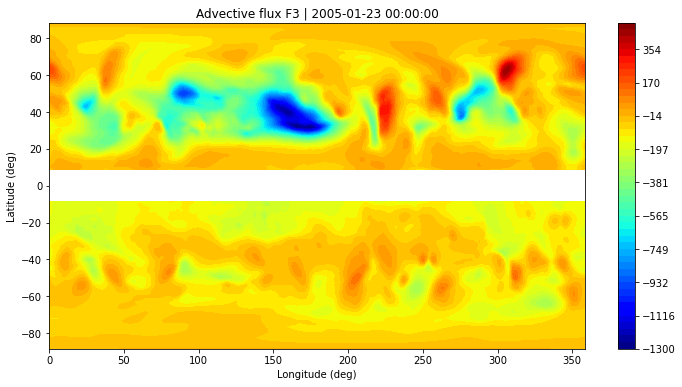

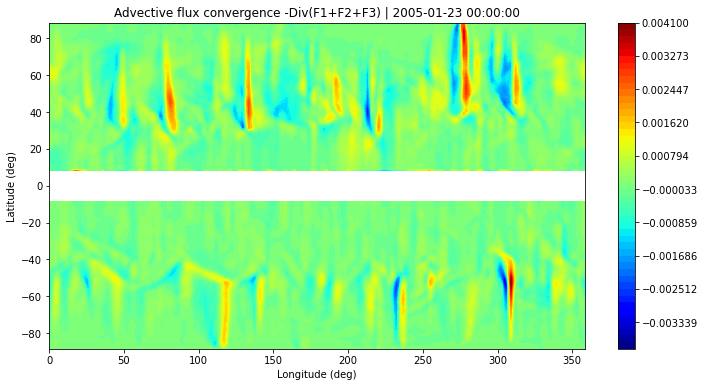

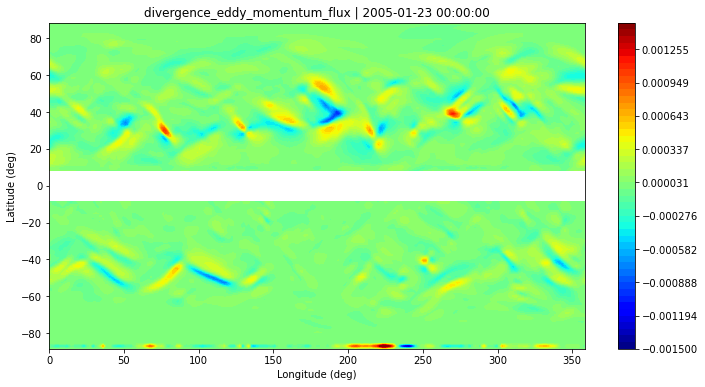

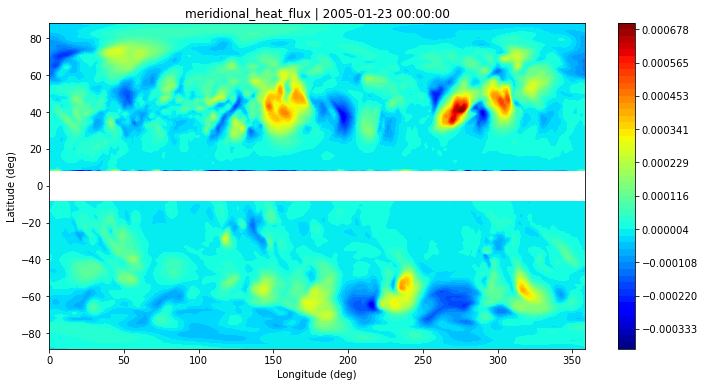

tstep = 0/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
num of nan in fawa: 2.
num of nan in fawa: 1.
tstep = 1/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
tstep = 2/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
num of nan in fawa: 1.
tstep = 3/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
num of nan in fawa: 1.
tstep = 4/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
tstep = 5/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
tstep = 6/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
tstep = 7/32

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
tstep = 8/32

 nlon, nlat, nlev, kmax, jd
         240         121          37      

In [8]:
for tstep in range(32):  # or ntimes
    
    uu = u_file.variables['u'][tstep, ::-1, ::-1, :].data
    vv = v_file.variables['v'][tstep, ::-1, ::-1, :].data
    tt = t_file.variables['t'][tstep, ::-1, ::-1, :].data

    qgfield_object = QGFieldNHN22(
        xlon, ylat, plev, uu, vv, tt, eq_boundary_index=eq_boundary_index)

    qgpv[tstep, :, :, :], interpolated_u[tstep, :, :, :], interpolated_v[tstep, :, :, :], \
        interpolated_theta[tstep, :, :, :], static_stability = qgfield_object.interpolate_fields()

    qref[tstep, :, :], uref[tstep, :, :], ptref[tstep, :, :] = \
        qgfield_object.compute_reference_states(northern_hemisphere_results_only=False)

    adv_flux_f1[tstep, :, :], \
    adv_flux_f2[tstep, :, :], \
    adv_flux_f3[tstep, :, :], \
    adv_flux_conv[tstep, :, :], \
    divergence_eddy_momentum_flux[tstep, :, :], \
    meridional_heat_flux[tstep, :, :], \
    lwa_baro[tstep, :, :], \
    u_baro[tstep, :, :], \
    lwa[tstep, :, :, :] \
        = qgfield_object.compute_lwa_and_barotropic_fluxes(northern_hemisphere_results_only=False)

    if tstep == tstep_selected:
        # === Below demonstrate another way to access the computed variables ===
        # 3D Variables that I would choose one pressure level to display
        variables_3d = [
            (qgfield_object.qgpv, 'Quasigeostrophic potential vorticity (QGPV)'),
            (qgfield_object.lwa, 'Local wave activity (LWA)'),
            (qgfield_object.interpolated_u, 'Interpolated zonal wind (u)'),
            (qgfield_object.interpolated_v, 'Interpolated meridional wind (v)')]

        # Reference states to be displayed on y-z plane
        variables_yz = [
            (qgfield_object.qref, 'Qref'),
            (qgfield_object.uref, 'Uref'),
            (qgfield_object.ptref, 'PTref')]

        # Vertically averaged variables to be displayed on x-y plane
        variables_xy = [
            (qgfield_object.adv_flux_f1, 'Advective flux F1'),
            (qgfield_object.adv_flux_f2, 'Advective flux F2'),
            (qgfield_object.adv_flux_f3, 'Advective flux F3'),
            (qgfield_object.convergence_zonal_advective_flux, 'Advective flux convergence -Div(F1+F2+F3)'),
            (qgfield_object.divergence_eddy_momentum_flux, 'divergence_eddy_momentum_flux'),
            (qgfield_object.meridional_heat_flux, 'meridional_heat_flux')
        ]
        
        # Plot 240 hPa of 3D-variables
        for variable, name in variables_3d:
            plt.figure(figsize=(12,4))
            plt.contourf(xlon, ylat[equator_idx:-1], variable[plev_selected, equator_idx:-1, :], 50, cmap='jet')
            if name=='Local wave activity (LWA)':
                plt.axhline(y=0, c='w', lw=30)
            plt.colorbar()
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.title(name + ' at 240hPa | ' + str(tstamp[tstep]))
            plt.show()
        
        # Plot reference states
        for variable, name in variables_yz:
            # Mask out equatorward region that is outside analysis boundary
            mask = np.zeros_like(variable)
            mask[:, equator_idx-eq_boundary_index-1:equator_idx+eq_boundary_index+1] = np.nan
            variable_masked = np.ma.array(variable, mask=mask)
            # Start plotting
            plt.figure(figsize=(6,4))
            plt.contourf(ylat[1:-1], height[1:-1], variable_masked[1:-1, 1:-1], 50, cmap='jet')
            plt.axvline(x=0, c='w', lw=2)
            plt.xlabel('Latitude (deg)')
            plt.ylabel('Pseudoheight (m)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()
            
        # Plot fluxes (color axies have to be fixed)
        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[0][0][1:-1, :], np.linspace(-100, 2401, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[0][1] + ' | ' + str(tstamp[tstep]))
        plt.show()

        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[1][0][1:-1, :], np.linspace(-1440, 1601, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[1][1] + ' | ' + str(tstamp[tstep]))
        plt.show()

        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[2][0][1:-1, :], np.linspace(-1300, 501, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[2][1] + ' | ' + str(tstamp[tstep]))
        plt.show()

        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[3][0][1:-1, :], np.linspace(-0.004, 0.0041, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[3][1] +' | ' + str(tstamp[tstep]))
        plt.show()

        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[4][0][1:-1, :], np.linspace(-0.0015, 0.0015, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[4][1] +' | ' + str(tstamp[tstep]))
        plt.show()

        plt.figure(figsize=(12,6))
        plt.contourf(xlon, ylat[1:-1], variables_xy[5][0][1:-1, :], np.linspace(-0.0004, 0.0007, 50), cmap='jet')
        plt.axhline(y=0, c='w', lw=30)
        plt.ylabel('Latitude (deg)')
        plt.xlabel('Longitude (deg)')
        plt.colorbar()
        plt.title(variables_xy[5][1] +' | ' + str(tstamp[tstep]))
        plt.show()

    print('tstep = {}/{}\n'.format(tstep, ntimes))
    
output_file.close()
print('Output {} timesteps of data to the file {}'.format(tstep + 1, output_fname))